# SSD vgg16 object detection demo

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

Disable auto scroll

In [2]:
from util.common import *
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [3]:
init_engine()

Verify and read some environment information (e.g. executor number and executor core number)

In [4]:
# load object class names
with open("data/cocosample/classname.txt") as f:
    classes = f.read().splitlines()

print classes
print 'In total ', len(classes), 'classes'

['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']
In total  81 classes


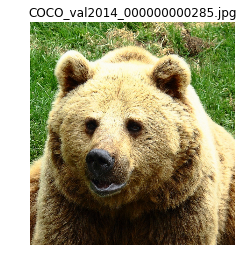

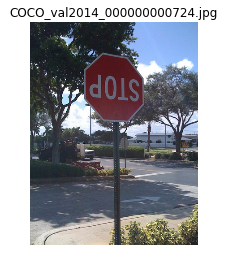

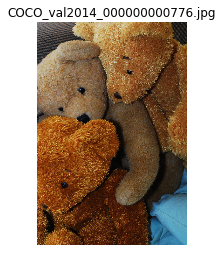

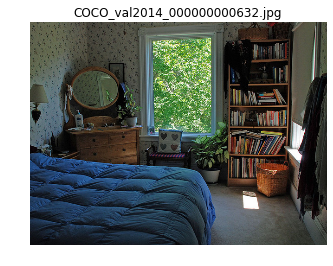

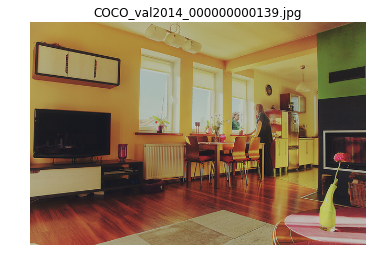

In [5]:
from scipy import misc
# load and show images
folder = "data/cocosample/images/val2014"
imageFiles = os.listdir(folder)
images = []
for f in imageFiles:
    image = mpimg.imread(folder + '/' + f)
    images.append(image)
    plt.imshow(image)
    plt.axis("off")
    plt.title(f)
    plt.show()

In [6]:
from nn.layer import Model
# load model
model = Model.load("data/ssd/ssd300x300coco.zoo.bigdl")
print 'load model done'

load model done


In [7]:
# data preprocess

means = np.array([104, 117, 123]) # mean value in BGR order
# resize to 300x300
# normalize by substracting channel mean values
# transpose the shape of image from (h, w, c) to (c, h, w)
# transform to sample
imgRdd = sc.parallelize(images)

sizes = imgRdd.map(lambda img: img.shape)

data = imgRdd.map(lambda original_img: misc.imresize(original_img, (300, 300))) \
.map(lambda resized_img: resized_img[:, :] - means) \
.map(lambda normalized_img: normalized_img.transpose(2, 0, 1)) \
.map(lambda normalized_img: Sample.from_ndarray(normalized_img, np.array([-1])))



In [8]:
output = model.predict(data)

In [9]:
def scaleOutput(output, img_size):
    total = int(output[0])
    detections = output[1:total*6 + 1].reshape(total, 6)
    height = img_size[0]
    width = img_size[1]
    # scale from (0, 1) to original image size
    detections[:, 2] *= width
    detections[:, 3] *= height
    detections[:, 4] *= width
    detections[:, 5] *= height
    return detections

result = output.zip(sizes).map(lambda (output_i, img_size):
    scaleOutput(output_i, img_size)
 ).collect()

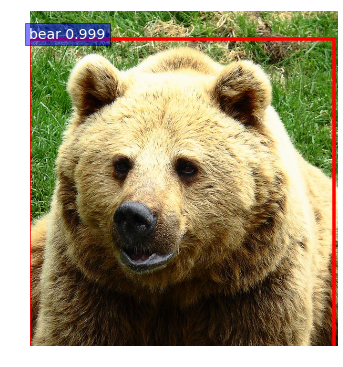

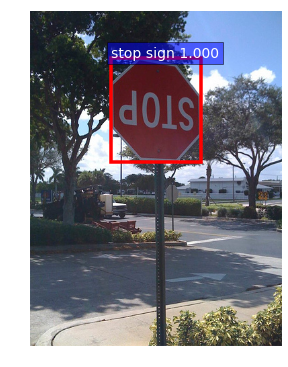

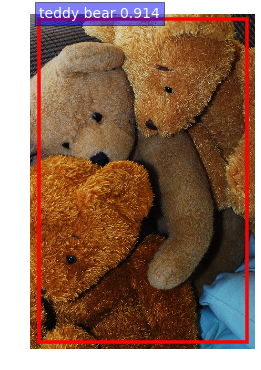

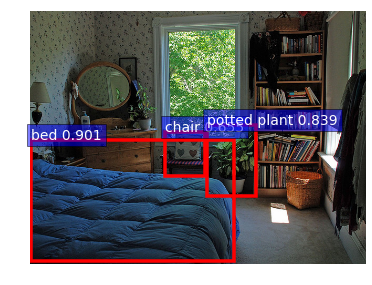

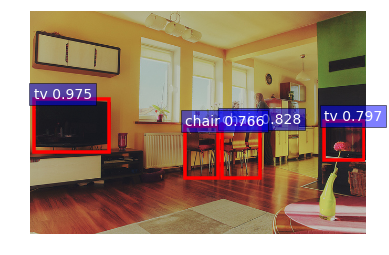

In [10]:
for img_id in range(len(result)):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(images[img_id])
    detections = result[img_id]
    total = detections.shape[0]
    
    for i in range(0, total):
        score = detections[i][1]
        cls_id = int(detections[i][0])
        if (score <= 0.6):
            continue
        ax.add_patch(
        plt.Rectangle((detections[i][2], detections[i][3]),
                      detections[i][4] - detections[i][2],
                      detections[i][5] - detections[i][3], fill=False,
                      edgecolor='red', linewidth=3.5)
        )
        ax.text(detections[i][2], detections[i][3] - 2,
            '{:s} {:.3f}'.format(classes[cls_id], score),
            bbox=dict(facecolor='blue', alpha=0.5),
            fontsize=14, color='white')
    plt.axis('off')
    plt.show()